In [288]:
from __future__ import (absolute_import, division, print_function)
import pandas as pd
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, MultiPolygon
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import *
import statistics
import math
from scipy.stats import pearsonr

In [56]:
def pgconnect():
    """
        Connect with data base
    """
    host = "soitpw11d59.shared.sydney.edu.au"
    user = "y21s1d2x01_qihe9584"
    pw = "500518061"
    database = "y21s1d2x01_qihe9584"
    #create data base engine
    db = create_engine('postgres+psycopg2://'+user+':'+pw+'@'+host+'/'+database, echo=False)
    # connect to data base
    conn = db.connect()
    return db,conn
db,conn = pgconnect()

In [ ]:
conn.execute("DROP TABLE IF EXISTS neighbourhoods CASCADE")
neighbourhoos_schema = """
                         CREATE TABLE IF NOT EXISTS neighbourhoods (
                         area_id INTEGER PRIMARY KEY,
                         area_name VARCHAR(100),
                         land_area FLOAT,
                         population INTEGER,
                         number_of_dwellings INTEGER,
                         number_of_businesses INTEGER,
                         median_annual_household_income INTEGER,
                         avg_monthly_rent INTEGER
                   )"""
conn.execute(neighbourhoos_schema)

In [67]:
"""
    clean and load neighbourhoods data
"""
neighbourhoods_data = pd.read_csv('Neighbourhoods.csv', thousands=",")
neighbourhoods_data2 = neighbourhoods_data.copy()
# drop the rows with NA value
neighbourhoods_data2 = neighbourhoods_data2.dropna()

# convert float to int
neighbourhoods_data2['population'] = neighbourhoods_data2['population'].astype(int)
neighbourhoods_data2['number_of_businesses'] = neighbourhoods_data2['number_of_businesses'].astype(int)
neighbourhoods_data2['median_annual_household_income'] = neighbourhoods_data2['median_annual_household_income'].astype(int)
neighbourhoods_data2['avg_monthly_rent'] = neighbourhoods_data2['avg_monthly_rent'].astype(int)

neighbourhoods_data2.to_sql('neighbourhoods', con=conn, if_exists='append',index=False)
res = pd.read_sql_query('SELECT * FROM neighbourhoods LIMIT 10', conn)
res 

,area_id,area_name,land_area,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent
0,102011028,Avoca Beach - Copacabana,643.8,7590,2325,738,46996,1906
1,102011029,Box Head - MacMasters Beach,3208.6,10986,3847,907,42621,1682
2,102011030,Calga - Kulnura,76795.1,4841,1575,1102,42105,1182
3,102011031,Erina - Green Point,3379.3,14237,4450,1666,43481,1595
4,102011032,Gosford - Springfield,1691.2,19385,6373,2126,45972,1382
5,102011033,Kariong,830.6,6540,1824,352,47896,1649
6,102011034,Kincumber - Picketts Valley,1208.9,7428,1946,479,41642,1397
7,102011035,Narara,770.2,6853,2006,292,46660,1512
8,102011036,Niagara Park - Lisarow,1673.2,8173,2345,477,45762,1495
9,102011037,Point Clare - Koolewong,678.7,6281,2220,312,45966,1572


In [38]:
pk_area_id = []
for index, row in neighbourhoods_data2.iterrows():
    pk_area_id.append(row['area_id'])

[102011028, 102011029, 102011030, 102011031, 102011032, 102011033, 102011034, 102011035, 102011036, 102011037, 102011038, 102011039, 102011040, 102011041, 102011042, 102011043, 102021044, 102021045, 102021046, 102021047, 102021048, 102021049, 102021050, 102021051, 102021052, 102021053, 102021054, 102021055, 102021056, 102021057, 115011290, 115011291, 115011294, 115011296, 115011553, 115011554, 115011555, 115011556, 115011557, 115011558, 115011559, 115021297, 115021298, 115031299, 115031300, 115041301, 115041302, 116011303, 116011304, 116011306, 116011307, 116011308, 116011560, 116011561, 116021309, 116021310, 116021312, 116021562, 116021563, 116031313, 116031314, 116031315, 116031316, 116031317, 116031319, 117011321, 117011322, 117011323, 117021326, 117021327, 117021328, 117031329, 117031330, 117031331, 117031332, 117031333, 117031334, 117031335, 117031336, 117031337, 117031338, 118011339, 118011340, 118011341, 118011343, 118011344, 118011345, 118011346, 118011347, 118021348, 118021350

In [ ]:
conn.execute("DROP TABLE IF EXISTS statisticalareas")
statisticalareas_schema = """
                         CREATE TABLE IF NOT EXISTS statisticalareas (
                         area_id INTEGER PRIMARY KEY,
                         area_name VARCHAR(100),
                         parent_area_id INTEGER
                   )"""
conn.execute(statisticalareas_schema)

In [68]:
"""
    clean and load statisticalareas data
"""
statisticalareas_data = pd.read_csv('StatisticalAreas.csv')
statisticalareas_data2 = statisticalareas_data.copy()
# drop the rows with same area_id
statisticalareas_data2.drop_duplicates(subset=['area_id'], keep='first', inplace=True)
statisticalareas_data2.to_sql('statisticalareas', con=conn, if_exists='append',index=False)

In [ ]:
conn.execute("DROP TABLE IF EXISTS businessstats")
businessstats_schema = """
                         CREATE TABLE IF NOT EXISTS businessstats (
                         area_id INTEGER,
                         area_name VARCHAR(100),
                         number_of_businesses INTEGER,
                         accommodation_and_food_services INTEGER,
                         retail_trade INTEGER,
                         agriculture_forestry_and_fishing INTEGER,
                         health_care_and_social_assistance INTEGER,
                         public_administration_and_safety INTEGER,
                         transport_postal_and_warehousing INTEGER,
                         
                         PRIMARY KEY(area_id),
                         CONSTRAINT fk_busi_neig
                         FOREIGN KEY(area_id)
                         REFERENCES neighbourhoods(area_id)
                   )"""
conn.execute(businessstats_schema)

In [70]:
businessstats_data = pd.read_csv('BusinessStats.csv')
businessstats_data2 = businessstats_data.copy()
rows_delete = []
# remove the rows has area_id that do not appear on neighbourhoods
for index, row in businessstats_data2.iterrows():
    if not row['area_id'] in pk_area_id:
        rows_delete.append(index)
businessstats_data2 = businessstats_data2.drop(rows_delete)
businessstats_data2.to_sql('businessstats', con=conn, if_exists='append',index=False)
res = pd.read_sql_query('SELECT * FROM businessstats', conn)
res 

,area_id,area_name,number_of_businesses,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing
0,101051540,Goulburn Region,1891,38,52,1041,33,3,81
1,102011028,Avoca Beach - Copacabana,724,33,35,4,60,0,19
2,102011029,Box Head - MacMasters Beach,934,23,45,13,43,3,28
3,102011030,Calga - Kulnura,1134,14,43,231,12,0,55
4,102011031,Erina - Green Point,1712,68,145,19,179,12,43
...,...,...,...,...,...,...,...,...,...
304,128021536,Oyster Bay - Como - Jannali,1655,52,84,15,92,11,120
305,128021538,Sutherland - Kirrawee,2136,73,113,6,127,17,122
306,128021607,Engadine,1106,37,69,3,82,9,51
307,128021608,Loftus - Yarrawarrah,452,9,20,3,25,5,31


In [ ]:
conn.execute("DROP TABLE IF EXISTS rfsnsw_bfpl")
rfsnsw_bfpl_schema = """CREATE TABLE IF NOT EXISTS rfsnsw_bfpl (
                         gid INTEGER PRIMARY KEY,
                         category INTEGER,
                         shape_leng FLOAT,
                         shape_area FLOAT,
                         geom GEOMETRY(POINT,4283)
                   )"""
conn.execute(rfsnsw_bfpl_schema)

In [114]:
rfsnsw_bfpl_data = gpd.read_file(os.path.join('./RFSNSW_BFPL_small', "RFSNSW_BFPL_small.shp"))

In [130]:
rfsnsw_bfpl_data.dtypes

CATEGORY         int64
SHAPE_LENG     float64
SHAPE_AREA     float64
geometry      geometry
dtype: object

In [116]:
# Use GeoAlchemy's WKTElement to create a geom with SRID
def create_wkt_point_element(geom,srid):
    return WKTElement(geom.wkt, srid)

rfsnsw_bfpl_data2 = rfsnsw_bfpl_data.copy()
#change columns name to lower case
rfsnsw_bfpl_data2.columns = map(str.lower, rfsnsw_bfpl_data2.columns)
rfsnsw_bfpl_data2['geom'] = rfsnsw_bfpl_data2['geometry'].apply(lambda x: create_wkt_point_element(x,4283))
rfsnsw_bfpl_data2["gid"] = rfsnsw_bfpl_data2.index
#delete the old column before insert
rfsnsw_bfpl_data2 = rfsnsw_bfpl_data2.drop(columns="geometry")

rfsnsw_bfpl_data2.to_sql('rfsnsw_bfpl', conn, if_exists='append', index=False, 
                         dtype={'geom': Geometry('POINT', 4283)})
res = pd.read_sql_query('SELECT * FROM rfsnsw_bfpl LIMIT 10', conn)
res 

,gid,category,shape_leng,shape_area,geom
0,0,1,0.000890,4.949777e-08,0101000020BB100000A6C14A5E9DBA6240BC28CBBA4626...
1,1,1,0.008990,1.417500e-06,0101000020BB100000B053865C6ABB6240A5762C7ED525...
2,2,1,0.011250,1.775249e-06,0101000020BB1000003603591AEABA6240E4C61C6CBA25...
3,3,1,0.001096,3.735098e-08,0101000020BB1000006EEAB2506BBA624081A4D314EE24...
4,4,1,0.027890,6.131269e-06,0101000020BB100000599ABD10D2B76240B1B4FAE98C22...
5,5,1,0.098110,7.132723e-05,0101000020BB100000845AA81CBCB86240D3FC625CC622...
6,6,1,0.001340,9.899752e-08,0101000020BB1000006B9604A8A9B762409992F4E2C421...
7,7,1,0.000890,4.949777e-08,0101000020BB100000DC871856F1B662406B6A6798DA1F...
8,8,1,0.049490,2.526973e-05,0101000020BB1000005E996CB0ECB76240EE4CE7DFF31F...
9,9,1,0.009450,1.568249e-06,0101000020BB100000E1331A9876B76240412721256F1F...


In [65]:
conn.execute("DROP TABLE IF EXISTS sa2_2016_aust")
sa2_2016_aust_schema = """CREATE TABLE IF NOT EXISTS sa2_2016_aust (
                         gid INTEGER PRIMARY KEY,
                         sa2_main16 INTEGER,
                         sa2_5dig16 INTEGER,
                         sa2_name16 VARCHAR(100),
                         sa3_code INTEGER,
                         sa3_name VARCHAR(100),
                         sa4_code INTEGER,
                         sa4_name VARCHAR(100),
                         gcc_code VARCHAR(100),
                         gcc_name VARCHAR(100),
                         ste_code INTEGER,
                         ste_name VARCHAR(100),
                         areasqkm16 FLOAT,
                         geom GEOMETRY(MULTIPOLYGON,4283),
                         
                         CONSTRAINT fk_sa2_neig
                         FOREIGN KEY(sa2_main16) 
                         REFERENCES neighbourhoods(area_id)
                   )"""
conn.execute(sa2_2016_aust_schema)

In [66]:
db.table_names()

['spatial_ref_sys',
 'nsw_bfpl',
 'world',
 'statisticalareas',
 'neighbourhoods',
 'businessstats',
 'rfsnsw_bfpl',
 'sa2_2016_aust']

In [115]:
sa2_2016_aust_data = gpd.read_file(os.path.join('./1270055001_sa2_2016_aust_shape', "SA2_2016_AUST.shp"))

In [135]:
# Use GeoAlchemy's WKTElement to create a geom with SRID
def create_wkt_element(geom,srid):
    if (geom.geom_type == 'Polygon'):
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

sa2_2016_aust_data2 = sa2_2016_aust_data.copy()

sa2_2016_aust_data2['SA2_MAIN16'] = sa2_2016_aust_data2['SA2_MAIN16'].astype(int)

#change columns name to lower case
sa2_2016_aust_data2.columns = map(str.lower, sa2_2016_aust_data2.columns)

# Rename columns
sa2_2016_aust_data2.rename(columns={
    'sa3_code16': 'sa3_code',
    'sa3_name16': 'sa3_name',
    'sa4_code16': 'sa4_code',
    'sa4_name16': 'sa4_name',
    'gcc_code16': 'gcc_code',
    'gcc_name16': 'gcc_name',
    'ste_code16': 'ste_code',
    'ste_name16': 'ste_name',
}, inplace=True)

# drop rows with None value
sa2_2016_aust_data2 = sa2_2016_aust_data2.dropna()

rows_delete = []
# remove the rows has area_id that do not appear on neighbourhoods
for index, row in sa2_2016_aust_data2.iterrows():
    if not row['sa2_main16'] in pk_area_id:
        rows_delete.append(index)
sa2_2016_aust_data2 = sa2_2016_aust_data2.drop(rows_delete)

sa2_2016_aust_data2["gid"] = sa2_2016_aust_data2.index

sa2_2016_aust_data2['geom'] = sa2_2016_aust_data2['geometry'].apply(lambda x: create_wkt_element(x,4283))
#delete the old column before insert
sa2_2016_aust_data2 = sa2_2016_aust_data2.drop(columns="geometry")

sa2_2016_aust_data2.to_sql('sa2_2016_aust', conn, if_exists='append', index=False, 
                         dtype={'geom': Geometry('MULTIPOLYGON', 4283)})

In [136]:
res = pd.read_sql_query('SELECT * FROM sa2_2016_aust', conn)
res 

,gid,sa2_main16,sa2_5dig16,sa2_name16,sa3_code,sa3_name,sa4_code,sa4_name,gcc_code,gcc_name,ste_code,ste_name,areasqkm16,geom
0,22,101051540,11540,Goulburn Region,10105,Goulburn - Mulwaree,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,9035.1221,0106000020BB10000001000000010300000002000000C0...
1,27,102011028,11028,Avoca Beach - Copacabana,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,6.4376,0106000020BB100000010000000103000000010000005E...
2,28,102011029,11029,Box Head - MacMasters Beach,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,32.0860,0106000020BB1000000100000001030000000100000000...
3,29,102011030,11030,Calga - Kulnura,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,767.9512,0106000020BB1000000200000001030000000100000085...
4,30,102011031,11031,Erina - Green Point,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,33.7934,0106000020BB1000000100000001030000000100000041...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,570,128021536,11536,Oyster Bay - Como - Jannali,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,8.9053,0106000020BB10000001000000010300000001000000EF...
305,572,128021538,11538,Sutherland - Kirrawee,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,7.7547,0106000020BB1000000100000001030000000100000089...
306,573,128021607,11607,Engadine,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,8.9538,0106000020BB100000010000000103000000010000008E...
307,574,128021608,11608,Loftus - Yarrawarrah,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,3.8436,0106000020BB10000001000000010300000001000000A1...


In [189]:
#create index on neighbourhoods's area_id since it is primary key
try:
    pd.read_sql_query("DROP INDEX IF EXISTS neig_idx;", conn)
except:
    pass

try:
    pd.read_sql_query("CREATE INDEX neig_idx ON neighbourhoods (area_id);", conn)
except:
    pass

In [190]:
pd.read_sql_query("""
                SELECT
                    indexname,
                    indexdef
                FROM
                    pg_indexes
                WHERE
                    tablename = 'neighbourhoods';
                """, conn)

,indexname,indexdef
0,neighbourhoods_pkey,CREATE UNIQUE INDEX neighbourhoods_pkey ON pub...
1,neig_idx,CREATE INDEX neig_idx ON public.neighbourhoods...


In [191]:
#create index on businessstats's area_id since it is foreign key
try:
    pd.read_sql_query("DROP INDEX IF EXISTS busi_idx;", conn)
except:
    pass

try:
    pd.read_sql_query("CREATE INDEX busi_idx ON businessstats (area_id);", conn)
except:
    pass

In [192]:
pd.read_sql_query("""
                SELECT
                    indexname,
                    indexdef
                FROM
                    pg_indexes
                WHERE
                    tablename = 'businessstats';
                """, conn)

,indexname,indexdef
0,businessstats_pkey,CREATE UNIQUE INDEX businessstats_pkey ON publ...
1,busi_idx,CREATE INDEX busi_idx ON public.businessstats ...


In [193]:
#create index on sa2_2016_aust's sa2_main16 since it is foreign key
try:
    pd.read_sql_query("DROP INDEX IF EXISTS sa2_idx;", conn)
except:
    pass

try:
    pd.read_sql_query("CREATE INDEX sa2_idx ON sa2_2016_aust (sa2_main16);", conn)
except:
    pass

In [195]:
try:
    pd.read_sql_query("DROP INDEX IF EXISTS sa2_geom_idx;", conn)
except:
    pass

#create spatial index on sa2_2016_aust
try:
    pd.read_sql_query("""
                    CREATE INDEX sa2_geom_idx
                      ON sa2_2016_aust
                      USING GIST (geom);
                    """, conn)
except:
    pass

In [196]:
try:
    pd.read_sql_query("DROP INDEX IF EXISTS rfsnsw_bfpl_geom_idx;", conn)
except:
    pass

#create spatial index on rfsnsw_bfpl
try:
    pd.read_sql_query("""
                    CREATE INDEX rfsnsw_bfpl_geom_idx
                      ON rfsnsw_bfpl
                      USING GIST (geom);
                    """, conn)
except:
    pass

In [197]:
    pd.read_sql_query("""
                    SELECT
                        indexname,
                        indexdef
                    FROM
                        pg_indexes
                    WHERE
                        tablename = 'sa2_2016_aust';
                    """, conn)

,indexname,indexdef
0,sa2_2016_aust_pkey,CREATE UNIQUE INDEX sa2_2016_aust_pkey ON publ...
1,sa2_idx,CREATE INDEX sa2_idx ON public.sa2_2016_aust U...
2,sa2_geom_idx,CREATE INDEX sa2_geom_idx ON public.sa2_2016_a...


In [198]:
    pd.read_sql_query("""
                    SELECT
                        indexname,
                        indexdef
                    FROM
                        pg_indexes
                    WHERE
                        tablename = 'rfsnsw_bfpl';
                    """, conn)

,indexname,indexdef
0,rfsnsw_bfpl_pkey,CREATE UNIQUE INDEX rfsnsw_bfpl_pkey ON public...
1,rfsnsw_bfpl_geom_idx,CREATE INDEX rfsnsw_bfpl_geom_idx ON public.rf...


In [245]:
data = pd.read_sql_query("""
                SELECT neighbourhoods.area_id, land_area, population, number_of_dwellings, neighbourhoods.number_of_businesses, 
                health_care_and_social_assistance, public_administration_and_safety, category, shape_area, sa2_2016_aust.geom AS sa2_geom, 
                rfsnsw_bfpl.geom AS bfpl_geom
                FROM neighbourhoods, businessstats, sa2_2016_aust, rfsnsw_bfpl
                WHERE neighbourhoods.area_id = businessstats.area_id AND
                    neighbourhoods.area_id = sa2_2016_aust.sa2_main16 AND 
                    ST_Contains(sa2_2016_aust.geom, rfsnsw_bfpl.geom)
                """, conn)

In [246]:
data.drop_duplicates(inplace=True)

In [247]:
data

,area_id,land_area,population,number_of_dwellings,number_of_businesses,health_care_and_social_assistance,public_administration_and_safety,category,shape_area,sa2_geom,bfpl_geom
0,101051540,9035.1221,12670,6817,1528,33,3,1,5.174863e-08,0106000020BB10000001000000010300000002000000C0...,0101000020BB1000000AA2C9F360B36240A4457F93A64A...
1,101051540,9035.1221,12670,6817,1528,33,3,1,1.318496e-06,0106000020BB10000001000000010300000002000000C0...,0101000020BB1000005F3A0BDA87B46240B3700CF55949...
2,101051540,9035.1221,12670,6817,1528,33,3,1,6.703782e-08,0106000020BB10000001000000010300000002000000C0...,0101000020BB100000DD7C22A1A1B4624025171193DB46...
3,101051540,9035.1221,12670,6817,1528,33,3,1,7.582451e-07,0106000020BB10000001000000010300000002000000C0...,0101000020BB10000059205C7365B4624007FD2CFBDC48...
4,101051540,9035.1221,12670,6817,1528,33,3,1,1.975503e-06,0106000020BB10000001000000010300000002000000C0...,0101000020BB10000081877F7969B4624030DB1E824049...
...,...,...,...,...,...,...,...,...,...,...,...
44510,128021608,384.4000,7426,2177,417,25,5,1,1.966105e-06,0106000020BB10000001000000010300000001000000A1...,0101000020BB100000F4169C98D1E06240F24F02BA5407...
44511,128021608,384.4000,7426,2177,417,25,5,2,6.339785e-07,0106000020BB10000001000000010300000001000000A1...,0101000020BB10000093B99385D7E062400CB02F43FF06...
44512,128021608,384.4000,7426,2177,417,25,5,2,8.782592e-07,0106000020BB10000001000000010300000001000000A1...,0101000020BB1000001B734B0C89E162407B4CD26F0006...
44513,128021609,313.7000,3681,1050,259,11,0,2,1.968288e-06,0106000020BB10000001000000010300000001000000F0...,0101000020BB1000003BB7BE50FEE06240A2D62C09FE03...


In [234]:
# all the area_id
neigh_area_ids = set(data['area_id'])
# map area_id to a list contains this neighbourhood's population density, dwelling_business density, bfpl density, assistive service density
id_data = {}
# store all neighbourhoods's data to calculate avg and std
population_densities = []
dwelling_business_densities = []
bfpl_densities = []
assistive_densities = []

# Traverse all the area_id and calculte their densities
for i in neigh_area_ids:
    temp = []
    df = data[data['area_id'] == i]
    # population density
    pd = df['population'].iloc[0] / df['land_area'].iloc[0]
    population_densities.append(pd)
    temp.append(pd)
    # dwelling_business density
    dbd = (df['number_of_dwellings'].iloc[0] + df['number_of_businesses'].iloc[0]) / df['land_area'].iloc[0]
    dwelling_business_densities.append(dbd)
    temp.append(dbd)
    # bfpl density
    # area and category is combined using area/category since 1 is the highest risk
    aux = df['shape_area'] / df['category']
    bd = aux.sum() / df['land_area'].iloc[0]
    bfpl_densities.append(bd)
    temp.append(bd)
    # assistive service density
    ad = (df['health_care_and_social_assistance'].iloc[0] + df['public_administration_and_safety'].iloc[0]) / df['land_area'].iloc[0]
    assistive_densities.append(ad)
    temp.append(ad)
    id_data[i] = temp


In [239]:
population_density_avg = sum(population_densities) / len(population_densities)
population_density_std = statistics.stdev(population_densities)

dwelling_business_density_avg = sum(dwelling_business_densities) / len(dwelling_business_densities)
dwelling_business_density_std = statistics.stdev(dwelling_business_densities)

bfpl_density_avg = sum(bfpl_densities) / len(bfpl_densities)
bfpl_density_std = statistics.stdev(bfpl_densities)

assistive_density_avg = sum(assistive_densities) / len(assistive_densities)
assistive_density_std = statistics.stdev(assistive_densities)

In [242]:
def z_population_density(x):
    return (x - population_density_avg) / population_density_std

def z_dwelling_business_density(x):
    return (x - dwelling_business_density_avg) / dwelling_business_density_std

def z_bfpl_density(x):
    return (x - bfpl_density_avg) / bfpl_density_std

def z_assistive_density(x):
    return (x - assistive_density_avg) / assistive_density_std

def s(x):
    return 1 / (1 + math.exp(-x))

In [265]:
sa2_2016_aust_data3 = sa2_2016_aust_data.copy()
sa2_2016_aust_data3['SA2_MAIN16'] = sa2_2016_aust_data3['SA2_MAIN16'].astype(int)
sa2_2016_aust_data3.dtypes

SA2_MAIN16       int64
SA2_5DIG16      object
SA2_NAME16      object
SA3_CODE16      object
SA3_NAME16      object
SA4_CODE16      object
SA4_NAME16      object
GCC_CODE16      object
GCC_NAME16      object
STE_CODE16      object
STE_NAME16      object
AREASQKM16     float64
geometry      geometry
dtype: object

In [281]:
neighbourhoods_data2

,area_id,area_name,land_area,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent
0,102011028,Avoca Beach - Copacabana,643.8000,7590.0,2325,738.0,46996.0,1906.0
1,102011029,Box Head - MacMasters Beach,3208.6000,10986.0,3847,907.0,42621.0,1682.0
2,102011030,Calga - Kulnura,76795.1000,4841.0,1575,1102.0,42105.0,1182.0
3,102011031,Erina - Green Point,3379.3000,14237.0,4450,1666.0,43481.0,1595.0
4,102011032,Gosford - Springfield,1691.2000,19385.0,6373,2126.0,45972.0,1382.0
...,...,...,...,...,...,...,...,...
317,106011109,Cessnock Region,1570.4341,7931.0,3281,673.0,73164.0,1080.0
318,106011113,Singleton Region,4067.2349,4919.0,2055,698.0,87984.0,1000.0
319,111021218,Morisset - Cooranbong,330.5208,14959.0,6298,1154.0,58084.0,1260.0
320,114021285,Hill Top - Colo Vale,174.3752,6025.0,2249,400.0,81120.0,1512.0


In [282]:
neig_geoms = []
fire_risks = []
neig_income = []
neig_rent = []
# calculate fire risk of each neighbourhoods
for i in neigh_area_ids:
    d = id_data[i]
    fr = s(z_population_density(d[0]) + z_dwelling_business_density(d[1]) + z_bfpl_density(d[2]) - z_assistive_density(d[3]))
    g = sa2_2016_aust_data3[sa2_2016_aust_data3['SA2_MAIN16'] == i]['geometry'].iloc[0]
    income = neighbourhoods_data2[neighbourhoods_data2['area_id'] == i]['median_annual_household_income'].iloc[0]
    rent = neighbourhoods_data2[neighbourhoods_data2['area_id'] == i]['avg_monthly_rent'].iloc[0]
    neig_geoms.append(g)
    fire_risks.append(fr)
    neig_income.append(income)
    neig_rent.append(rent)

In [277]:
%matplotlib inline
map_df = pd.DataFrame(
    {'fire_risk': fire_risks,
     'geom': neig_geoms
    })
gpd_map_df = gpd.GeoDataFrame(map_df, geometry='geom')

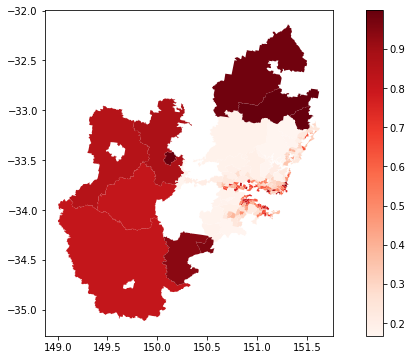

In [280]:
fig, ax = plt.subplots(1, figsize=(12,6))
gpd_map_df.plot(ax=ax, cmap='Reds', column='fire_risk', legend=True)

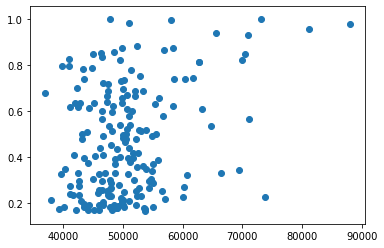

Pearsons correlation: 0.29455856183304896


In [290]:
plt.scatter(neig_income, fire_risks)
plt.show()

corr, _ = pearsonr(neig_income, fire_risks)
print('Pearsons correlation: {}'.format(corr))

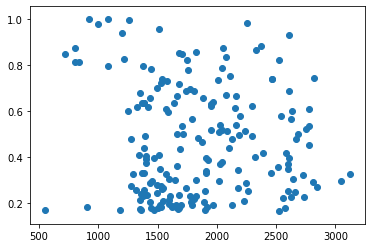

Pearsons correlation: -0.06830049136978633


In [291]:
plt.scatter(neig_rent, fire_risks)
plt.show()
corr, _ = pearsonr(neig_rent, fire_risks)
print('Pearsons correlation: {}'.format(corr))